In [1]:
import sys 
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
%load_ext autoreload
%autoreload 2
from relation import Distribution

In [4]:
dis = Distribution(62.5,'140','')

[]

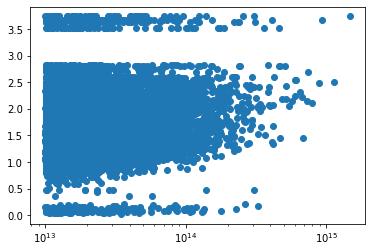

In [5]:
plt.scatter(dis.dataframe['m500c[Msol]'], dis.dataframe['galaxy_number_density'])
plt.semilogx()

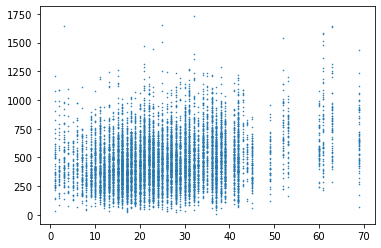

In [6]:
plt.scatter(dis.dataframe['num_clusters'],dis.dataframe['Veff'], s=.3)

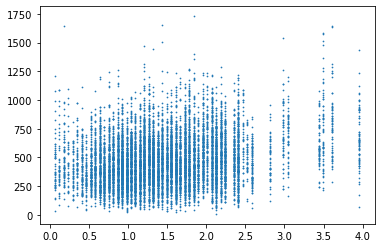

In [7]:
plt.scatter(dis.dataframe['cluster_number_density'],dis.dataframe['Veff'], s=.5)


[]

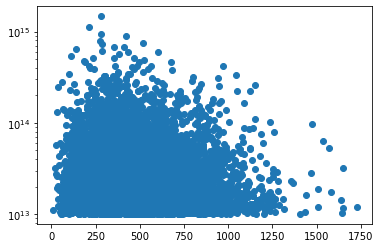

In [8]:
plt.scatter(dis.dataframe['Veff'], dis.dataframe['m500c[Msol]'])
plt.semilogy()

In [9]:
dis.dataframe

,x,y,z,m500c[Msol],Veff,num_clusters,cluster_number_density,num_galaxies,galaxy_number_density
0,298153.400000,291274.728571,499578.614286,1.475457e+15,282.734776,61,3.499666,6391,3.735072
1,448729.014286,34781.574286,397226.342857,8.947214e+14,420.658838,32,1.835891,4247,2.482061
2,119680.368571,295014.357143,207021.871429,1.132550e+15,210.422788,32,1.835891,4283,2.503100
3,262471.185714,276172.371429,475365.714286,2.571843e+14,1151.476184,61,3.499666,6391,3.735072
4,467593.442857,333224.285714,299148.500000,9.369229e+14,283.361004,63,3.614410,6265,3.661435
...,...,...,...,...,...,...,...,...,...
10488,350761.042857,68432.064286,468116.785714,1.011257e+13,423.034247,17,0.975317,2957,1.728150
10489,133957.020000,115844.374286,361266.342857,1.036896e+13,313.121018,21,1.204803,2460,1.437690
10490,236012.385714,94692.455714,82792.935714,1.026654e+13,208.150635,15,0.860574,2400,1.402625
10491,93738.750000,219882.857143,4596.666143,1.075313e+13,646.156878,49,2.811207,4246,2.481477
